### DATA processing

In [75]:
import os 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
#Assinging the path 
Dataset_dir = "D:/Guvi/Projects/TB Detection/Data/Dataset of Tuberculosis Chest X-rays Images"
Normal_dir = os.path.join(Dataset_dir, "Normal Chest X-rays")
TB_dir = os.path.join(Dataset_dir, "TB Chest X-rays")

img_size = (224, 224)
Batch_size = 32


In [4]:
#check for any corrupt files:
def check_images(path):
    try:
        img =Image.open(path)
        img.verify()
        return True
    except:
        return False

In [5]:
def valid_images_path(folder):
    valid_img = []
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        if check_images(path):
            valid_img.append(path)
    return valid_img

In [6]:
normal_images = valid_images_path(Normal_dir)
TB_images = valid_images_path(TB_dir)

print(f"Valid Normal Images :{len(normal_images)}")
print(f"Valid TB Images :{len(TB_images)}")

Valid Normal Images :514
Valid TB Images :2494


In [7]:
#creating Label & combining the data set :
normal_label = [0]*len(normal_images)
tb_label = [1]*len(TB_images)

images_paths = normal_images+TB_images
labels = normal_label+tb_label

In [8]:
#splitting the data:

from sklearn.model_selection import train_test_split

X_train, X_temp , y_train, y_temp = train_test_split(
    images_paths, 
    labels,
    test_size= 0.30,
    stratify=labels,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

In [44]:
#Loading Data:
from tensorflow.keras.applications import resnet50, vgg16
def get_preprocess_fn(model_type = 'resnet'):
    def load_and_preprocess(path, label):
        #common image handler
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, img_size)

        if model_type =='resnet':
            img = resnet50.preprocess_input(img)
        elif model_type == 'effb0':
            img = tf.cast(img, tf.float32)
        elif model_type == 'vgg16':
            img = vgg16.preprocess_input(img)
        else:
            img = img/255.0
        return img, label
    return load_and_preprocess

In [36]:
#creating tensors:
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_validation_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
raww_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

#Preprocessing: for resnet
preprocess_for_resnet = get_preprocess_fn('resnet')
train_ds_res = raw_train_ds.map(preprocess_for_resnet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_res = raw_validation_ds.map(preprocess_for_resnet, num_parallel_calls= tf.data.AUTOTUNE)
test_ds_res = raww_test_ds.map(preprocess_for_resnet, num_parallel_calls= tf.data.AUTOTUNE)

#Batch Processing:
res_train_ready = train_ds_res.shuffle(1000).batch(Batch_size).prefetch(tf.data.AUTOTUNE)
res_val_ready = val_ds_res.batch(Batch_size).prefetch(tf.data.AUTOTUNE)
res_test_ready = test_ds_res.batch(Batch_size).prefetch(tf.data.AUTOTUNE)

In [37]:
#Preprocessing: for effb0
preprocess_for_eff = get_preprocess_fn('effb0')
train_ds_eff = raw_train_ds.map(preprocess_for_eff, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_eff = raw_validation_ds.map(preprocess_for_eff, num_parallel_calls= tf.data.AUTOTUNE)
test_ds_eff = raww_test_ds.map(preprocess_for_eff, num_parallel_calls= tf.data.AUTOTUNE)

#Batch Processing:
eff_train_ready = train_ds_eff.shuffle(1000).batch(Batch_size).prefetch(tf.data.AUTOTUNE)
eff_val_ready = val_ds_eff.batch(Batch_size).prefetch(tf.data.AUTOTUNE)
eff_test_ready = test_ds_eff.batch(Batch_size).prefetch(tf.data.AUTOTUNE)

In [38]:
#Preprocessing: for vgg16
preprocess_for_eff = get_preprocess_fn('vgg16')
train_ds_vgg = raw_train_ds.map(preprocess_for_eff, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_vgg = raw_validation_ds.map(preprocess_for_eff, num_parallel_calls= tf.data.AUTOTUNE)
test_ds_vgg = raww_test_ds.map(preprocess_for_eff, num_parallel_calls= tf.data.AUTOTUNE)

#Batch Processing:
vgg_train_ready = train_ds_vgg.shuffle(1000).batch(Batch_size).prefetch(tf.data.AUTOTUNE)
vgg_val_ready = val_ds_vgg.batch(Batch_size).prefetch(tf.data.AUTOTUNE)
vgg_test_ready = test_ds_vgg.batch(Batch_size).prefetch(tf.data.AUTOTUNE)

In [40]:
#Data Augmentation:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.02),
    tf.keras.layers.RandomZoom(0.1)
])

In [41]:
def augment (img, label):
    img = data_augmentation(img, training = True)
    return img, label

In [42]:
res_aug_train_ds = res_train_ready.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
eff_aug_train_ds = eff_train_ready.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
vgg_aug_train_ds = vgg_train_ready.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

### EDA

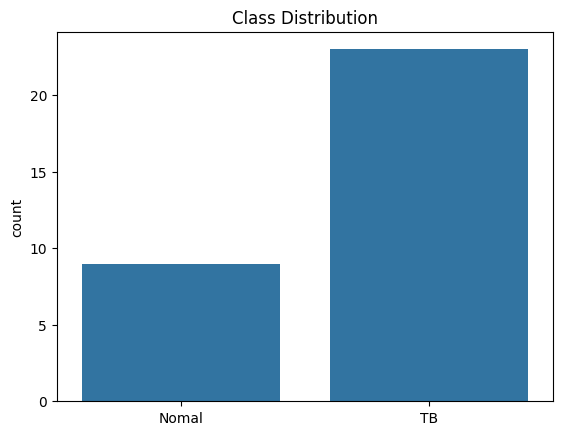

In [43]:
#viz image distribution:

import seaborn as sns
sns.countplot(x=labels)
plt.xticks([0,1], ["Nomal","TB"])
plt.title("Class Distribution")
plt.show()

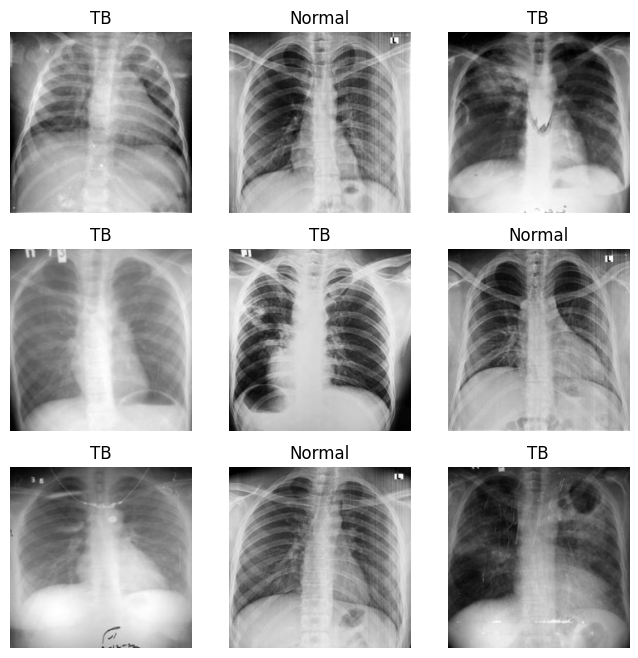

In [45]:
#class Balance:
#taking data without augmentation
viz_preprocess = get_preprocess_fn()
viz_ds = raw_train_ds.map(viz_preprocess). batch(32)


for images, labels in viz_ds.take(1):
    plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i][:,:,0], cmap='gray')
        plt.title("TB" if labels[i]==1 else 'Normal')
        plt.axis('off')
    plt.show()

In [49]:
#pixel intesity check:
def collect_pixels_by_class(X,y, n_images=100, model_type = 'none'):
    """
    X:List of file paths
    y: Lables
    """
    tb_pixels = []
    nor_pixels=[]

    #get the preprocessing function:
    preprocess_fn = get_preprocess_fn(model_type=model_type)

    y=np.array(y).reshape(-1)

    tb_idx = np.where(y==1)[0][:n_images]
    nor_idx = np.where(y==0)[0][:n_images]

    for idx in tb_idx:
        img, _ = preprocess_fn(X[idx], 1)
        tb_pixels.append(tf.reshape(img[:,:,0],[-1]))
    for idx in nor_idx:
        img,_=preprocess_fn(X[idx], 0)
        nor_pixels.append(tf.reshape(img[:,:,0],[-1]))
    
    #conerting the tesnors to numpy arrays for the ploting 
    tb_pixels=tf.concat(tb_pixels, axis=0).numpy()
    nor_pixels = tf.concat(nor_pixels, axis=0).numpy()

    return tb_pixels, nor_pixels

In [50]:
tb_pixels, nor_pixels = collect_pixels_by_class(X_train, y_train, n_images=100, model_type='none')

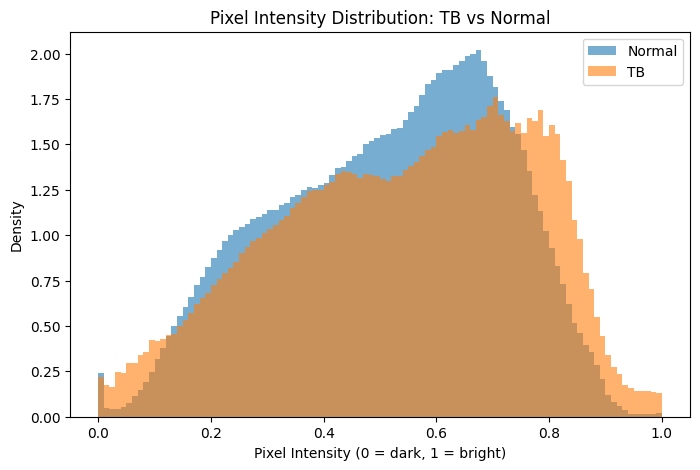

In [51]:
plt.figure(figsize=(8,5))

plt.hist(nor_pixels, bins=100, alpha=0.6, label="Normal", density=True)
plt.hist(tb_pixels, bins=100, alpha=0.6, label="TB", density=True)

plt.xlabel("Pixel Intensity (0 = dark, 1 = bright)")
plt.ylabel("Density")
plt.title("Pixel Intensity Distribution: TB vs Normal")
plt.legend()
plt.show()

### Model

In [18]:
#Handling class imbalance:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(
    class_weight= 'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight = dict(enumerate(class_weight))
class_weight

{0: np.float64(2.923611111111111), 1: np.float64(0.6031518624641834)}

In [29]:
#Needed metrics:
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy

In [57]:
#prerequisites:
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras import layers, models

In [ ]:
#Model training:
def build_model(base_model,lr=1e-4, dropout_rate=0.5 ):
    base_model.trainable =False
    model = keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    #for compiling:
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        loss = 'binary_crossentropy',
        metrics = [
            BinaryAccuracy(name = 'accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='roc_auc')
        ]
    )
    return model

In [22]:
#1 Resnet 50:
resnet_base = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

resnet_model = build_model(resnet_base)
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [55]:
#callbacks:
def get_callbacks(model_name):
    return [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath = f"{model_name}_tb_best.keras",
        monitor = 'val_loss',
        save_best_only = True
    ),
    #additional model metrics save:
    tf.keras.callbacks.CSVLogger(f"{model_name}_training_log.csv")
]

res_callbacks  =get_callbacks('resnet50')
eff_callbacks = get_callbacks('efficiebtnetb0')
vgg_callbacks = get_callbacks('vgg16')

In [56]:
#training:
training_on_resnet = resnet_model.fit(
    res_train_ready, 
    validation_data = res_val_ready,
    epochs =30,
    class_weight = class_weight,
    callbacks = res_callbacks
)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.0328 - loss: 1.3549 - precision: 0.9240 - recall: 0.6468 - roc_auc: 0.7780 - val_accuracy: 0.0377 - val_loss: 0.6126 - val_precision: 1.0000 - val_recall: 0.7914 - val_roc_auc: 0.9826
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.0625 - loss: 0.2007 - precision: 0.9986 - recall: 0.8774 - roc_auc: 0.9877 - val_accuracy: 0.0421 - val_loss: 0.1759 - val_precision: 1.0000 - val_recall: 0.9091 - val_roc_auc: 0.9960
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.0949 - loss: 0.1626 - precision: 0.9983 - recall: 0.9188 - roc_auc: 0.9896 - val_accuracy: 0.0599 - val_loss: 0.0693 - val_precision: 1.0000 - val_recall: 0.9786 - val_roc_auc: 0.9973
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.1351 - loss: 0.0693 - precision: 0.9990 - recall: 0.9575 - roc_auc: 0.9981 - val_accuracy: 0.0710 - val_loss: 0.0395 - val_precision: 1.0000 - val_recall: 0.9893 - val_roc_auc: 1.0000
Epoch 5/

In [ ]:
#testing fine tuning:
#loading the prev trained set so that the model dont train from the first
best_res_model= tf.keras.models.load_model("resnet50_tb_best.keras")

best_res_model.trainable = True
for layers in model.layers[:-50]:
    layers.trainable = False

best_res_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss = 'binary_crossentropy',
              metrics = [
                  BinaryAccuracy(name = 'accuracy'),
                  Precision(name='precision'),
                  Recall(name='recall'),
                  AUC(name='roc_auc')
                  ]
              )

In [ ]:
resnet_fine_tune = best_res_model.fit(
    res_train_ready, 
    validation_data = res_val_ready,
    epochs =5,
    class_weight = class_weight
)

Epoch 1/5


66/66 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9938 - loss: 0.0133 - precision: 0.9996 - recall: 0.9929 - roc_auc: 0.9999 - val_accuracy: 0.9978 - val_loss: 0.0033 - val_precision: 1.0000 - val_recall: 0.9973 - val_roc_auc: 1.0000
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9912 - loss: 0.0134 - precision: 1.0000 - recall: 0.9894 - roc_auc: 1.0000 - val_accuracy: 0.9978 - val_loss: 0.0030 - val_precision: 1.0000 - val_recall: 0.9973 - val_roc_auc: 1.0000
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9930 - loss: 0.0167 - precision: 0.9988 - recall: 0.9928 - roc_auc: 0.9999 - val_accuracy: 0.9978 - val_loss: 0.0031 - val_precision: 1.0000 - val_recall: 0.9973 - val_roc_auc: 1.0000
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9955 - loss: 0.0163 - precision: 0.9977 - recall: 0.9967 - roc_auc: 0.9999 - val_accuracy: 0.9978 - val_loss: 0.0032 - val_precision: 1.0000 - val_recall: 0.9973 - val_roc_auc: 1.0000
Epoch 5/5
66/66 ━━━━━━

In [62]:
#Model 2 - EfficientNetB0:
#defining the model
eff_base = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

eff_model = build_model(eff_base)
eff_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,788 (16.09 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [63]:
#training the model:
eff_training = eff_model.fit(
    eff_train_ready, 
    validation_data = eff_val_ready,
    epochs=20,
    class_weight = class_weight,
    callbacks = eff_callbacks
)

Epoch 1/20


66/66 ━━━━━━━━━━━━━━━━━━━━ 49s 627ms/step - accuracy: 0.7324 - loss: 0.6737 - precision: 0.9176 - recall: 0.7402 - roc_auc: 0.7858 - val_accuracy: 0.9557 - val_loss: 0.3004 - val_precision: 0.9972 - val_recall: 0.9492 - val_roc_auc: 0.9984
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 604ms/step - accuracy: 0.8276 - loss: 0.2982 - precision: 0.9861 - recall: 0.8023 - roc_auc: 0.9609 - val_accuracy: 0.9601 - val_loss: 0.2326 - val_precision: 1.0000 - val_recall: 0.9519 - val_roc_auc: 0.9990
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 635ms/step - accuracy: 0.8804 - loss: 0.2122 - precision: 0.9959 - recall: 0.8595 - roc_auc: 0.9813 - val_accuracy: 0.9645 - val_loss: 0.1850 - val_precision: 1.0000 - val_recall: 0.9572 - val_roc_auc: 0.9995
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 641ms/step - accuracy: 0.9082 - loss: 0.1686 - precision: 0.9916 - recall: 0.8962 - roc_auc: 0.9854 - val_accuracy: 0.9645 - val_loss: 0.1497 - val_precision: 1.0000 - val_recall: 0.9572 - val_roc_auc: 0.9997
Epoch 5

In [64]:
#fine tunning:

best_eff_model = tf.keras.models.load_model("efficiebtnetb0_tb_best.keras")

best_eff_model.trainable  = True

for layers in best_eff_model.layers[:-20]:
    layers.trainable = False

best_eff_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics = [BinaryAccuracy(name='accuracy'),
                             Precision(name='precision'),
                             Recall(name='recall'),
                             AUC(name='roc_auc')])

print('Starting to fine tune.....')
eff_fine_tuning_history = best_eff_model.fit(
    eff_train_ready,
    validation_data = eff_val_ready,
    epochs = 5,
    class_weight = class_weight,
    callbacks = eff_callbacks
)

Starting to fine tune.....
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 49s 620ms/step - accuracy: 0.9863 - loss: 0.0406 - precision: 0.9992 - recall: 0.9838 - roc_auc: 0.9988 - val_accuracy: 0.9867 - val_loss: 0.0328 - val_precision: 1.0000 - val_recall: 0.9840 - val_roc_auc: 1.0000
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 595ms/step - accuracy: 0.9857 - loss: 0.0365 - precision: 0.9981 - recall: 0.9844 - roc_auc: 0.9994 - val_accuracy: 0.9867 - val_loss: 0.0323 - val_precision: 1.0000 - val_recall: 0.9840 - val_roc_auc: 1.0000
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 592ms/step - accuracy: 0.9855 - loss: 0.0375 - precision: 0.9991 - recall: 0.9832 - roc_auc: 0.9994 - val_accuracy: 0.9867 - val_loss: 0.0319 - val_precision: 1.0000 - val_recall: 0.9840 - val_roc_auc: 1.0000
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 591ms/step - accuracy: 0.9845 - loss: 0.0367 - precision: 0.9990 - recall: 0.9821 - roc_auc: 0.9995 - val_accuracy: 0.9867 - val_loss: 0.0320 - val_precision: 1.0000 - val_recall: 0.

In [69]:
#model 3 vgg16:
vgg_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224,224,3)
)

vgg_model = build_model(vgg_base)

In [70]:
vgg_training = vgg_model.fit(
    vgg_train_ready, 
    validation_data = vgg_val_ready,
    epochs= 20,
    class_weight = class_weight,
    callbacks = vgg_callbacks
)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 238s 4s/step - accuracy: 0.4635 - loss: 1.0233 - precision: 0.8935 - recall: 0.3955 - roc_auc: 0.6276 - val_accuracy: 0.7228 - val_loss: 0.6028 - val_precision: 1.0000 - val_recall: 0.6658 - val_roc_auc: 0.9694
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.6327 - loss: 0.6252 - precision: 0.9886 - recall: 0.5637 - roc_auc: 0.8699 - val_accuracy: 0.8093 - val_loss: 0.4372 - val_precision: 1.0000 - val_recall: 0.7701 - val_roc_auc: 0.9886
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.7574 - loss: 0.4063 - precision: 0.9921 - recall: 0.7090 - roc_auc: 0.9461 - val_accuracy: 0.8537 - val_loss: 0.3273 - val_precision: 1.0000 - val_recall: 0.8235 - val_roc_auc: 0.9945
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.7963 - loss: 0.3514 - precision: 0.9891 - recall: 0.7609 - roc_auc: 0.9507 - val_accuracy: 0.8847 - val_loss: 0.2544 - val_precision: 1.0000 - val_recall: 0.8610 - val_roc_auc: 0.9972
Epoc

In [ ]:
best_vgg_model = tf.keras.models.load_model("vgg16_tb_best.keras")

#Identify the base layer
vgg_base = best_vgg_model.layers[0]

vgg_base.trainable=True

for layers in vgg_base.layers:
    if 'block5' in layers.name:
        layers.trainable = True
    else:
        layers.trainable = False

#Ensuring custom head is always trainable:
for layer in best_vgg_model.layers[1:]:
    layer.trainable = True

for i, layer in enumerate(best_vgg_model.layers):
    print(f"layer{i}:{layer.name} | trainable : {layer.trainable}")

layer0:vgg16 | trainable : True
layer1:global_average_pooling2d_4 | trainable : True
layer2:batch_normalization_4 | trainable : True
layer3:dropout_8 | trainable : True
layer4:dense_8 | trainable : True
layer5:dropout_9 | trainable : True
layer6:dense_9 | trainable : True


In [ ]:
best_vgg_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = 'binary_crossentropy',
    metrics = [
        BinaryAccuracy(name = 'accuracy'),
        Precision(name = 'precision'),
        Recall(name = 'recall'),
        AUC(name = 'roc_auc')
    ]
)

print("Fine Tuning....")
vgg_tuning_model = best_vgg_model.fit(
    vgg_train_ready, 
    validation_data = vgg_val_ready,
    epochs = 5,
    class_weight = class_weight,
    callbacks = vgg_callbacks
)

Fine Tuning....
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.9798 - loss: 0.0480 - precision: 0.9984 - recall: 0.9771 - roc_auc: 0.9989 - val_accuracy: 0.9933 - val_loss: 0.0167 - val_precision: 1.0000 - val_recall: 0.9920 - val_roc_auc: 1.0000
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.9888 - loss: 0.0311 - precision: 1.0000 - recall: 0.9862 - roc_auc: 0.9996 - val_accuracy: 0.9956 - val_loss: 0.0094 - val_precision: 1.0000 - val_recall: 0.9947 - val_roc_auc: 1.0000
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9898 - loss: 0.0224 - precision: 0.9978 - recall: 0.9897 - roc_auc: 0.9999 - val_accuracy: 1.0000 - val_loss: 0.0046 - val_precision: 1.0000 - val_recall: 1.0000 - val_roc_auc: 1.0000
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9961 - loss: 0.0133 - precision: 1.0000 - recall: 0.9953 - roc_auc: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0048 - val_precision: 1.0000 - val_recall: 1.0000 - val_roc_auc:

In [78]:
#Evaluating the models:
def evaluate_model(model, test_ds):
    y_prob = model.predict(test_ds).flatten()
    y_pred = (y_prob >0.5).astype(int)
    y_true = np.concatenate([y for x, y in test_ds], axis=0).flatten()

    #check:
    if len(y_true)!= len(y_pred):
        print(f"Warning : Lable count Mismatch")
    
    return y_true, y_pred, y_prob

In [79]:
#calling in the tuned models:
tuned_res_model = tf.keras.models.load_model("resnet50_tb_best.keras")
tuned_eff_model = tf.keras.models.load_model("efficiebtnetb0_tb_best.keras")
tuned_vgg_model = tf.keras.models.load_model("vgg16_tb_best.keras")

In [83]:
#report, 
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, accuracy_score,recall_score,precision_score

#resnet
evaluation_list = [
    {"name": "Resnet50", "model": tuned_res_model, "test_ds":res_test_ready},
    {"name": "EfficientNetB0", "model": tuned_eff_model, "test_ds":eff_test_ready},
    {"name": "VGG16", "model": tuned_vgg_model, "test_ds":vgg_test_ready}
]

all_results = []

print("Evaluating Multi-Model...")

for item in evaluation_list:
    name = item["name"]
    model = item['model']
    test_ds = item['test_ds']

    print(f"\nEvaluating {name}..")

    y_true, y_pred,y_prob = evaluate_model(model, test_ds)

    metrics = {
        "Model":name,
        "Accuracy":accuracy_score(y_true, y_pred),
        "Precision":precision_score(y_true, y_pred),
        "Recall":recall_score(y_true, y_pred),
        "F1-Score":f1_score(y_true, y_pred),
        "Roc_Auc" : roc_auc_score(y_true, y_prob)
    }

    all_results.append(metrics)

results_df = pd.DataFrame(all_results)
print("\n" + "="*50)
print("FINAL MODEL COMPARISION TABLE")
print("="*50)
print(results_df.to_string(index=False))

Evaluating Multi-Model...

Evaluating Resnet50..
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step

Evaluating EfficientNetB0..
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 479ms/step

Evaluating VGG16..
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step

FINAL MODEL COMPARISION TABLE
         Model  Accuracy  Precision   Recall  F1-Score  Roc_Auc
      Resnet50  0.995575        1.0 0.994667  0.997326 1.000000
EfficientNetB0  0.975664        1.0 0.970667  0.985115 0.999861
         VGG16  0.993363        1.0 0.992000  0.995984 1.000000
